# Crossmodal project: Figure 2

In [5]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import cmocean
import sys
sys.path.append(os.getcwd()+'\\..')

sys.path.append(r'..\..\calculate_choice_prob')
import calculate_auc as ca

import calculate_auc as ca

from utils import utils
import utils2
import plotting_utils as pu
import matplotlib.patches as patches
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [6]:
importlib.reload(utils);
importlib.reload(pu);

## If exporting figures for adobe illustrator

In [7]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 6}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6)
mpl.rc('axes', labelsize=6)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## If plotting for inline visualization

In [8]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', labelsize=16)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Load and process main data file that was exported from matlab. 


In [36]:
DATA_DIR = os.path.abspath('../data')
log_df = pd.read_hdf(os.path.join(DATA_DIR, 'log_df_processed_02-28-2019.h5'), 'fixed')
unit_key_df = pd.read_hdf(os.path.join(DATA_DIR, 'unit_key_df_processed_02-28-2019.h5'), 'fixed')

C:\Users\Eric\Documents\09-12-2021\crossmodal\Figure2\..\utils\utils.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  licks = licks.applymap(lambda y: y[[0.1<y]] if len(y) > 0 else y)
C:\Users\Eric\Documents\09-12-2021\crossmodal\Figure2\..\utils\utils.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  licks = licks.applymap(lambda y: y[[3>=y]] if len(y) > 0 else y)


## Calculate Z-scores for each unit
#### determine baseline windows and calculate spike count histograms

In [37]:
bin_size = 0.025

In [38]:
# ITI is added on to the beginning of each trial therefore stim-onset time is a direct measure of ITI length.
# will restrict baseline periods to 0.5 s before stim onset - periods will be [-stimOnset to -0.5]
baseline_df = pd.DataFrame(-np.column_stack((log_df['stim_onset'], np.repeat(0.5, len(log_df['stim_onset'])))),
                  columns = ['baseline_min', 'baseline_max'])
log_df = pd.concat((log_df.reset_index(drop=True), baseline_df), axis=1)

# remove all trials with dropped stim-onsets that are due to premature licking
log_df['baseline_min'] = log_df['baseline_min'].replace(0, np.nan)
log_df = log_df.dropna(subset = ['baseline_min'])

# remove all trials with short ITIs and truncate ITIs of trials with ITIs longer than 3.5s
log_df = log_df.loc[log_df['baseline_min'] <= -3.5]  
log_df.loc[:, 'baseline_min'] = -3.5

edges = np.arange(-3.5, -1, bin_size)
log_df['baseline_spike_count'] = [np.histogram(trial_spikes, edges)[0] for trial_spikes in log_df['spike_times(stim_aligned)']]

In [39]:
def unit_stats(uni_id):
    unit_rows = log_df[(log_df['uni_id'] == uni_id)]
    
    baseline_trial_inds = rand.sample(list(unit_rows.index), int(np.max(unit_rows['trial_num'])/8))
    bin_means = np.mean(np.stack(unit_rows.loc[baseline_trial_inds, 
                                               'baseline_spike_count'].values, axis = 0), axis=0)/bin_size
    unit_ind = np.where(unit_key_df['uni_id'] == uni_id)[0]
    unit_key_df.loc[unit_ind,'FR_mean'] = np.mean(bin_means)
    unit_key_df.loc[unit_ind,'FR_std'] = np.std(bin_means)
    
[unit_stats(unit_key_df.loc[x, 'uni_id']) for x in tnrange(len(unit_key_df['uni_id']))];

C:\Users\Eric\AppData\Local\Temp/ipykernel_5100/4101982689.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  [unit_stats(unit_key_df.loc[x, 'uni_id']) for x in tnrange(len(unit_key_df['uni_id']))];


  0%|          | 0/2931 [00:01<?, ?it/s]

### Calculate mean spike rate histograms for each trial type in order to use for Z-Score calculation
#### important: np.histogram counts all positive values from and including the start of the bin until but not including the start of the next bin

In [40]:
#%pdb
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)
log_df['spike_counts(stim_aligned)'] = log_df['spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)
conds = ['Touch Stim LR', 'Touch Stim LL', 'Touch Stim NL','Visual Stim LL','Visual Stim LR', 'Visual Stim NL']

z_conds = ['Touch Stim LR(z_score)', 'Touch Stim LL(z_score)', 'Touch Stim NL(z_score)',
           'Visual Stim LL(z_score)','Visual Stim LR(z_score)', 'Visual Stim NL(z_score)']
for c in range(6):
    unit_key_df[conds[c]] = np.nan
    unit_key_df[conds[c]] = unit_key_df[conds[c]].astype(object)
    unit_key_df[z_conds[c]] = np.nan
    unit_key_df[z_conds[c]] = unit_key_df[z_conds[c]].astype(object)

#### Calculate Z-scores for each trial type for each unit

In [41]:
whisker = log_df['block_type'] == 'Whisker'
visual = log_df['block_type'] == 'Visual'
correct = log_df['correct'] == 1
lick = log_df['response'] != 0
lick_right = log_df['response'] == 1
lick_left = log_df['response'] == 2

t_stim = log_df['trial_type'].str.contains('Som')
v_stim = log_df['trial_type'].str.contains('Vis')

tt_key = pd.DataFrame()
tt_key['ts_hit'] = (t_stim  & whisker & correct)
tt_key['ts_cr'] = (t_stim & visual & correct)
tt_key['ts_fa'] = (t_stim & lick & ~correct)
tt_key['ts_miss'] = (t_stim & whisker & ~lick)
tt_key['vs_hit'] = (v_stim & visual & correct)
tt_key['vs_fa'] = (v_stim & lick & ~correct)
tt_key['vs_cr'] = (v_stim & whisker & correct)
tt_key['vs_miss'] = (v_stim & visual & ~lick)

tt_key['ts_fa_r'] = (t_stim & lick_right & ~correct)
tt_key['ts_fa_l'] = (t_stim & lick_left & ~correct)

tt_key['vs_fa_r'] = (v_stim & lick_right & ~correct)
tt_key['vs_fa_l'] = (v_stim & lick_left & ~correct)

tt_key['ts_lr'] = (t_stim  & lick_right)
tt_key['ts_ll'] = (t_stim & lick_left)
tt_key['ts_nl'] = (t_stim & ~lick)
tt_key['vs_ll'] = (v_stim & lick_left)
tt_key['vs_lr'] = (v_stim & lick_right)
tt_key['vs_nl'] = (v_stim & ~lick)

tt_key.head(2)

,ts_hit,ts_cr,ts_fa,ts_miss,vs_hit,vs_fa,vs_cr,vs_miss,ts_fa_r,ts_fa_l,vs_fa_r,vs_fa_l,ts_lr,ts_ll,ts_nl,vs_ll,vs_lr,vs_nl
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True


In [42]:
%pdb

Automatic pdb calling has been turned OFF


In [43]:
def calc_zscore(ind):
    unit_key_id = unit_key_df.loc[ind, 'uni_id']
    unit_row_inds = log_df['uni_id'] == unit_key_df.loc[ind, 'uni_id']
    unit_rows = log_df[unit_row_inds]
    unit_tt = tt_key[unit_row_inds]
      
    trial_types = [unit_tt['ts_lr'],unit_tt['ts_ll'], unit_tt['ts_nl'], unit_tt['vs_ll'],
                   unit_tt['vs_lr'], unit_tt['vs_nl']]
    bin_means_all = []
    for j in range(6):
        tt_rows = unit_rows[trial_types[j].values]
        if len(tt_rows['spike_counts(stim_aligned)'].values)<1:
            bin_means = np.array([np.nan]*159)
        else:
            bin_means = np.mean(np.stack(tt_rows['spike_counts(stim_aligned)'].values, axis = 0), axis=0)
            
        baseline_mean = unit_key_df.loc[ind, 'FR_mean']
        baseline_std = unit_key_df.loc[ind, 'FR_std']
        
        unit_key_df.loc[ind,conds[j]] = [[bin_means]]
        unit_key_df.loc[ind,z_conds[j]] = [[(bin_means - baseline_mean)/baseline_std]]

[calc_zscore(ind) for ind in tnrange(unit_key_df.shape[0])];

C:\Users\Eric\AppData\Local\Temp/ipykernel_5100/2541726793.py:23: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  [calc_zscore(ind) for ind in tnrange(unit_key_df.shape[0])];


  0%|          | 0/2931 [00:00<?, ?it/s]

In [44]:
# log_df.to_hdf('log_df_processed.h5', 'table')
# unit_key_df.to_hdf('unit_key_df_processsed.h5', 'table')

In [45]:
act_resp_window = np.round(([0,.500] + np.abs(window[0]))/bin_size) -1

##need to do this in two parts otherwise python crashes
act_resp = unit_key_df.loc[:,z_conds].applymap(lambda y: y[int(act_resp_window[0]):int(act_resp_window[1])])
act_resp  = act_resp.applymap(lambda y: np.nanmean(y))

unit_key_df['activation_resp'] = act_resp['Touch Stim LR(z_score)'] 

C:\Users\Eric\AppData\Local\Temp/ipykernel_5100/2290928270.py:5: RuntimeWarning: Mean of empty slice
  act_resp  = act_resp.applymap(lambda y: np.nanmean(y))


In [46]:
#### !! 24 neurons were recorded in sessions where the mouse did not make any touch-FA - for presentation purposes I have 
#### removed the two sessions containing those neurons
sub_map = unit_key_df.sort_values(['activation_resp'], ascending = True)
z_scored_df = sub_map
# z_scored_df.to_hdf('z_scored_df.h5', 'table') 
# no_FA_rows = (sub_map['Touch Stim FA'].apply(lambda x: all(np.isnan(x))) |
#               sub_map['Visual Stim FA'].apply(lambda x: all(np.isnan(x))))
# inf_rows = (sub_map['Touch Stim Hit(z_score)'].apply(lambda x: any(np.isinf(x))) |
#             sub_map['Visual Stim Hit(z_score)'].apply(lambda x: any(np.isinf(x))))
# sub_map = sub_map.loc[~no_FA_rows & ~inf_rows]

In [47]:
sub_map = sub_map[~(sub_map['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))] # these are mice with tetrodes not implanted in pricipal whisker
sub_map['mouse_name'].unique()

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0084',
       'EF0088', 'EF0089', 'EF0091', 'EF0099', 'EF0101', 'EF0102',
       'EF0114'], dtype=object)

In [48]:
cont_grps = log_df[['mouse_name', 'contingency']].drop_duplicates().groupby('contingency')
sub_map2 = sub_map.merge(cont_grps.get_group('fwd'), on = 'mouse_name', how = 'inner').sort_values('activation_resp')
sub_map2['mouse_name'].unique()

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0084',
       'EF0088', 'EF0089', 'EF0114'], dtype=object)

In [49]:
# fig2b_1.savefig('fig2b_1.pdf',format='pdf', dpi=900, transparent = True)
# fig2b_2.savefig('fig2b_2.pdf',format='pdf', dpi=900, transparent = True)

In [51]:
%pdb

Automatic pdb calling has been turned ON


Text(0.5, 0.98, 'Touch lick-right/Visual lick-left')

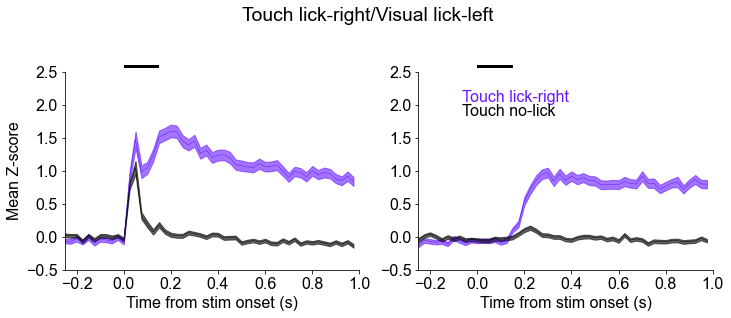

In [55]:
# data = {}
# columns = ['Touch Stim LR(z_score)', 'Touch Stim LL(z_score)', 'Touch Stim NL(z_score)',
#            'Visual Stim LL(z_score)','Visual Stim LR(z_score)', 'Visual Stim NL(z_score)']
# for i,col in enumerate(columns):
#     data[i] = [pd.DataFrame(np.stack(sub_map[z_map].values)) for z_map in col]


data = {}
columns = [['Touch Stim LR(z_score)','Touch Stim NL(z_score)'],
           ['Visual Stim LL(z_score)','Visual Stim NL(z_score)']]

# columns = [['Touch Stim Hit(z_score)', 'Touch Stim Miss(z_score)', 
#             'Touch Stim FA(z_score)','Touch Stim CR(z_score)'],
#            ['Visual Stim Hit(z_score)','Visual Stim Miss(z_score)', 
#             'Visual Stim FA(z_score)', 'Visual Stim CR(z_score)']]

for i,col in enumerate(columns):
    data[i] = [pd.DataFrame(np.squeeze(np.stack(sub_map2[z_map].values))) for z_map in col]
    
importlib.reload(pu);
fig = pu.plot_zscore_psth(data, [-0.25, 1.01], bin_size, ['#6619ff', 'k'], labels = ['Touch lick-right', 'Touch no-lick'])
fig.set_size_inches(12,5)
fig.suptitle('Touch lick-right/Visual lick-left')
# fig.savefig('mean_zscore_psths_Lick.pdf',format='pdf', dpi=900, transparent = True)


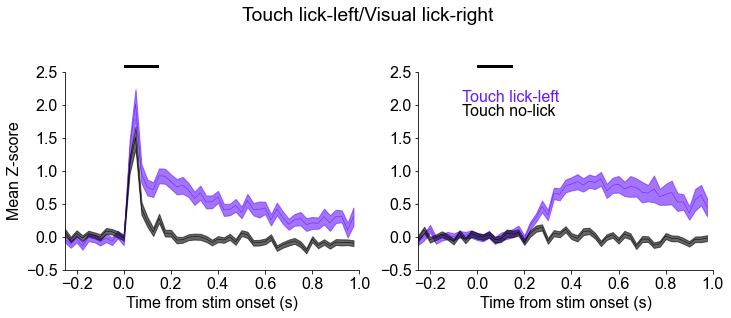

In [56]:
sub_map3 = sub_map[~(sub_map['mouse_name'].isin(['EF0083', 'EF0085', 'EF0111', 'EF0112']))]
sub_map3 = sub_map3.merge(cont_grps.get_group('rev'), on = 'mouse_name', how = 'inner').sort_values('activation_resp')
sub_map3 = sub_map3.iloc[:-1, :]
data = {}
columns = [['Touch Stim LL(z_score)','Touch Stim NL(z_score)'],
           ['Visual Stim LR(z_score)','Visual Stim NL(z_score)']]
for i,col in enumerate(columns):
    data[i] = [pd.DataFrame(np.squeeze(np.stack(sub_map3[z_map].values))) for z_map in col]
    
importlib.reload(pu);
fig = pu.plot_zscore_psth(data, [-0.25, 1.01], bin_size, ['#6619ff', 'k'], labels = ['Touch lick-left', 'Touch no-lick'])
fig.set_size_inches(12,5)
fig.suptitle('Touch lick-left/Visual lick-right')
fig.savefig('mean_zscore_psths_rev_lick_no_lick.pdf',format='pdf', dpi=900, transparent = True)


In [58]:
tactile_lick_noLick_aucs = pd.read_hdf(r'..\..\DATA\Crossmodal_only\Touch_lick_no_lick_auc_2019-02-27.h5', 'table')
visual_lick_noLick_aucs = pd.read_hdf(r'..\..\DATA\Crossmodal_only\Visual_lick_no_lick_auc_2019-02-27.h5', 'table')

In [59]:
sub_map2 = sub_map2[sub_map2['uni_id'].isin(unit_key_df2['uni_id'])]
fwd_tac_units = sub_map2['uni_id'].drop_duplicates().to_frame()
rev_tac_units =  sub_map3['uni_id'].drop_duplicates().to_frame()

In [60]:
def prettify_ax(ax, x_label, y_label, y_lim = None, x_lim = None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if y_lim:
        ax.set_ylim(y_lim)
        
    if x_lim:
        ax.set_xlim(x_lim)     
    return ax

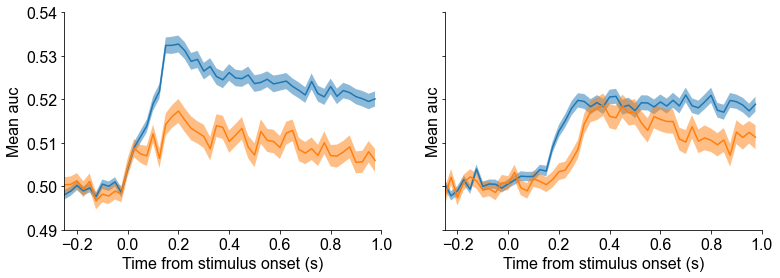

In [61]:
fig, axes = mpl.subplots(1,2, figsize = (12.5,4), sharey = True)

for ax, trial_type in zip(axes, [tactile_lick_noLick_aucs, visual_lick_noLick_aucs]):
    
    for grp in [fwd_tac_units, rev_tac_units]:
        aucs = trial_type.merge(grp, on = 'uni_id')
        aucs = aucs.loc[:, aucs.columns[aucs.columns.str.contains('auc')]]
        mean = aucs.mean(axis = 0)[30:80]
        sem = (np.std(aucs, axis = 0)/np.sqrt(aucs.shape[0]))[30:80]
        x_range = np.arange(-0.25, 1, 0.025)
        ax.plot(x_range, mean)
        ax.fill_between(x_range, mean-sem, mean+sem, alpha = 0.5)
        ax.set_xticks(np.arange(-0.2,1.2,0.2))
#         ax.axvline(x=0.15)
    prettify_ax(ax, 'Time from stimulus onset (s)', 'Mean auc', x_lim = (-0.25,1.0), y_lim = (.49,.54))
    

fig.savefig('fwd_vs_rev_contingency_aucs.pdf', format = 'pdf', dpi =900)

In [62]:
def get_spike_counts(unit_df, pos_tt, neg_tt, pos_resp, neg_resp):
    
    pos_trials = (unit_df['trial_type'] == pos_tt) & (unit_df['response'].isin(pos_resp))
    neg_trials = (unit_df['trial_type'] == neg_tt) & (unit_df['response'].isin(neg_resp))

    func = lambda x: np.histogram(x, bins = [0,0.15])[0]/0.15
    spike_counts_pos = unit_df.loc[pos_trials, 'spike_times(stim_aligned)'].apply(func).to_frame()
    spike_counts_neg = unit_df.loc[neg_trials, 'spike_times(stim_aligned)'].apply(func).to_frame()
    
    spike_counts_pos.loc[:, 'label'] = 1
    spike_counts_neg.loc[:, 'label'] = 0
    
    spike_counts = pd.concat([spike_counts_pos,spike_counts_neg]).values
    
    return np.vstack(spike_counts[:,:-1]), spike_counts[:,-1].astype(int)

In [63]:
### calculate auc during first 150 ms after stimulus onset for units recorded in tactile-lick right mice
log_df_fwd = log_df.merge(fwd_tac_units, on = 'uni_id')
grouped_log = log_df_fwd[['uni_id', 'trial_type', 'response', 'spike_times(stim_aligned)']].groupby('uni_id')

spike_counts = [get_spike_counts(unit, 'Stim_Som_NoCue', 'Stim_Som_NoCue', [1], [0]) for _, unit in grouped_log]
auc = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts)]
auc = np.squeeze(auc)[:,0]


C:\Users\Eric\AppData\Local\Temp/ipykernel_5100/4209606182.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  auc = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts)]


  0%|          | 0/1539 [00:00<?, ?it/s]

In [64]:
### calculate auc during first 150 ms after stimulus onset for units recorded in tactile-lick right mice
log_df_rev = log_df.merge(rev_tac_units, on = 'uni_id')
grouped_log = log_df_rev[['uni_id', 'trial_type', 'response', 'spike_times(stim_aligned)']].groupby('uni_id')

spike_counts2 = [get_spike_counts(unit, 'Stim_Som_NoCue', 'Stim_Som_NoCue', [2], [0]) for _, unit in grouped_log]
auc2 = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts2)]
auc2 = np.squeeze(auc2)[:,0]

C:\Users\Eric\AppData\Local\Temp/ipykernel_5100/828277286.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  auc2 = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts2)]


  0%|          | 0/549 [00:00<?, ?it/s]

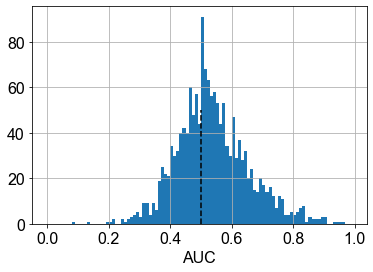

In [65]:
pd.Series(auc).hist(bins = np.arange(0,1, 0.01))
mpl.xlabel('AUC')
mpl.plot([0.5,0.5], [0,50], 'k--')

In [66]:
ttest_results = stats.ttest_ind(auc, auc2)
print(f't-test results comparing auc values for first 150 ms after stimulus onset between units recorded from tactile LR and tactile LL: {ttest_results[1]:.3f}')

t-test results comparing auc values for first 150 ms after stimulus onset between units recorded from tactile LR and tactile LL: 0.014


In [70]:
fwd_tac_units

,uni_id
0,07401-03-161t1
1,07401-03-162t1
2,07401-03-162t2
3,07401-03-165t1
4,07401-03-165t2
...,...
1552,11406-01-187t1
1553,11406-01-187t2
1554,11406-01-187t3
1555,11406-01-188t1


In [77]:
### calculate auc during first 150 ms after stimulus onset for units recorded in tactile-lick right mice
log_df_fwd = log_df.merge(fwd_tac_units, on = 'uni_id')
grouped_log = log_df_fwd[['uni_id', 'trial_type', 'response', 'spike_times(stim_aligned)']].groupby('uni_id')

spike_counts = [get_spike_counts(unit, 'Stim_Vis_NoCue', 'Stim_Vis_NoCue', [2], [0]) for _, unit in grouped_log]
auc = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts)]
auc = np.squeeze(auc)[:,0]


C:\Users\Eric\AppData\Local\Temp/ipykernel_5100/369470665.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  auc = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts)]


  0%|          | 0/1539 [00:00<?, ?it/s]

In [76]:
### calculate auc during first 150 ms after stimulus onset for units recorded in tactile-lick right mice
log_df_rev = log_df.merge(rev_tac_units, on = 'uni_id')
grouped_log = log_df_rev[['uni_id', 'trial_type', 'response', 'spike_times(stim_aligned)']].groupby('uni_id')

spike_counts2 = [get_spike_counts(unit, 'Stim_Vis_NoCue', 'Stim_Vis_NoCue', [1], [0]) for _, unit in grouped_log]
auc2 = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts2)]
auc2 = np.squeeze(auc2)[:,0]

C:\Users\Eric\AppData\Local\Temp/ipykernel_5100/2856869369.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  auc2 = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts2)]


  0%|          | 0/549 [00:00<?, ?it/s]

In [78]:
ttest_results = stats.ttest_ind(auc, auc2)
print(f't-test results comparing auc values for first 150 ms after stimulus onset between units recorded from visual LR and visual LL: {ttest_results[1]:.3f}')

t-test results comparing auc values for first 150 ms after stimulus onset between units recorded from tactile LR and tactile LL: 0.545


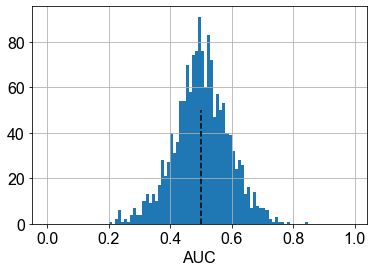

In [81]:
pd.Series(auc).hist(bins = np.arange(0,1, 0.01))
mpl.xlabel('AUC')
mpl.plot([0.5,0.5], [0,50], 'k--')

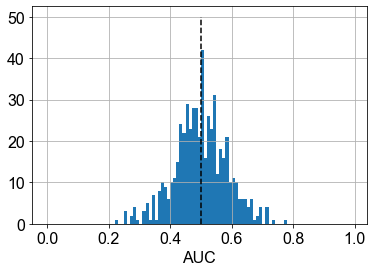

In [82]:
pd.Series(auc2).hist(bins = np.arange(0,1, 0.01))
mpl.xlabel('AUC')
mpl.plot([0.5,0.5], [0,50], 'k--')

In [83]:
len(auc2)

549